#Loan Default Prediction

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Packages and Data Loading

In [ ]:
!pip install imbalanced-learn

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.combine import SMOTEENN
from collections import Counter
from imblearn.over_sampling import SMOTE
from tqdm.notebook import tqdm

In [ ]:
pd.set_option('display.float_format', '{:.2f}'.format)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/loan_data.csv')

In [ ]:
df.head(5)

,Loan ID,Customer ID,Loan Status,Loan Amount,Term,Credit Score,Annual Income,Purpose,Number of Open Accounts
0,14dd8831-6af5-400b-83ec-68e61888a048,981165ec-3274-42f5-a3b4-d104041a9ca9,Fully Paid,445412,Short Term,709.00,1167493.00,Home Improvements,6
1,4771cc26-131a-45db-b5aa-537ea4ba5342,2de017a3-2e01-49cb-a581-08169e83be29,Fully Paid,262328,Short Term,NaN,NaN,Debt Consolidation,35
2,4eed4e6a-aa2f-4c91-8651-ce984ee8fb26,5efb2b2b-bf11-4dfd-a572-3761a2694725,Fully Paid,99999999,Short Term,741.00,2231892.00,Debt Consolidation,18
3,77598f7b-32e7-4e3b-a6e5-06ba0d98fe8a,e777faab-98ae-45af-9a86-7ce5b33b1011,Fully Paid,347666,Long Term,721.00,806949.00,Debt Consolidation,9
4,d4062e70-befa-4995-8643-a0de73938182,81536ad9-5ccf-4eb8-befb-47a4d608658e,Fully Paid,176220,Short Term,NaN,NaN,Debt Consolidation,15


In [ ]:
df.sample(5)

,Loan ID,Customer ID,Loan Status,Loan Amount,Term,Credit Score,Annual Income,Purpose,Number of Open Accounts
9561,a4093df5-b83f-4e9f-9e12-ed3307b5c090,b0a19deb-50bf-47d8-aaab-1f78edd658c8,Fully Paid,192500,Short Term,745.00,539486.00,Debt Consolidation,10
57002,5c9582fa-e822-48cf-b1cc-ef0a8d7a9529,0ef782e5-f35c-4075-af2a-7daa2c01bf20,Fully Paid,264550,Short Term,NaN,NaN,Debt Consolidation,4
96596,1d00f1f1-d576-4669-b337-5e00fba58028,6e704909-308c-4e94-815c-45bd49ffa346,Fully Paid,90420,Short Term,NaN,NaN,Debt Consolidation,4
5800,fd2528ab-f667-404b-bb82-457306a8caac,8fa5368d-9681-4812-a616-f1dd53140920,Fully Paid,444224,Short Term,NaN,NaN,Debt Consolidation,9
71463,da7a4837-e91c-4d82-83c2-5342b8c68f84,b013fa3b-3b4d-4573-829b-d90afddbd596,Fully Paid,79376,Short Term,700.00,590235.00,vacation,15


##Data Understanding & Cleaning

In [ ]:
#IDs are not helpful for loan default prediction, so droping off those
df.drop(columns=["Loan ID","Customer ID"],inplace=True)

In [ ]:
df['Loan Status'].value_counts()

,count
Loan Status,
Fully Paid,77361
Charged Off,22639


In [ ]:
df.shape

(100000, 7)

In [ ]:
df[df["Credit Score"].isnull()]['Loan Status'].value_counts()

,count
Loan Status,
Fully Paid,13725
Charged Off,5429


Above table shows that your target variable Loan Status is imbalanced:

Fully Paid: 13,725 (Approx 72%) <br>
Charged Off: 5,429 (Approx 28%)<br>

Marking this as key point and will try model building before and after handling imbalance the dataset and it's evaluation score.

### Null Value Handling

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Loan Status              100000 non-null  object 
 1   Loan Amount              100000 non-null  int64  
 2   Term                     100000 non-null  object 
 3   Credit Score             80846 non-null   float64
 4   Annual Income            80846 non-null   float64
 5   Purpose                  100000 non-null  object 
 6   Number of Open Accounts  100000 non-null  int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 5.3+ MB


As

In [ ]:
print(df[df['Loan Status']=='Fully Paid']["Annual Income"].median()-df[df['Loan Status']=='Charged Off']["Annual Income"].median())

127214.5


In [ ]:
print(df[df['Loan Status']=='Fully Paid']["Credit Score"].median()-df[df['Loan Status']=='Charged Off']["Credit Score"].median())

-7.0


As per above analysis, There is no much difference in Average value of Annual Income and Credit score based on fully paid/charged off loan status so will impute the null values for entire dataset

In [ ]:
df['Credit Score'].fillna(df['Credit Score'].median(), inplace=True)
df['Annual Income'].fillna(df['Annual Income'].median(), inplace=True)

<ipython-input-13-faf51f9b4639>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Credit Score'].fillna(df['Credit Score'].median(), inplace=True)
<ipython-input-13-faf51f9b4639>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inpl

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Loan Status              100000 non-null  object 
 1   Loan Amount              100000 non-null  int64  
 2   Term                     100000 non-null  object 
 3   Credit Score             100000 non-null  float64
 4   Annual Income            100000 non-null  float64
 5   Purpose                  100000 non-null  object 
 6   Number of Open Accounts  100000 non-null  int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 5.3+ MB


### Outlier

In [ ]:
df.describe()

,Loan Amount,Credit Score,Annual Income,Number of Open Accounts
count,100000.00,100000.00,100000.00,100000.00
mean,11760447.39,1008.95,1339180.46,11.13
std,31783942.55,1333.83,975609.51,5.01
min,10802.00,585.00,76627.00,0.00
25%,179652.00,711.00,931180.50,8.00
50%,312246.00,724.00,1174162.00,10.00
75%,524942.00,738.00,1512704.00,14.00
max,99999999.00,7510.00,165557393.00,76.00


by seeing describe, we get to know that almost all the column has outlier, will use IQR technique to handle this.

In [ ]:
def outlier_range(col_name): #here am creating a function to check IQR value, Lower/Upper Bound
    Q1 = df[col_name].quantile(0.25)
    Q3 = df[col_name].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    print(f"IQR: {IQR}")
    print(f"Lower Bound: {lower_bound}")
    print(f"Upper Bound: {upper_bound}")
    sns.boxplot(x=df[col_name])
    plt.title(f"Box Plot - {col_name}")
    plt.show()


####Loan Amount

IQR: 345290.0
Lower Bound: -338283.0
Upper Bound: 1042877.0


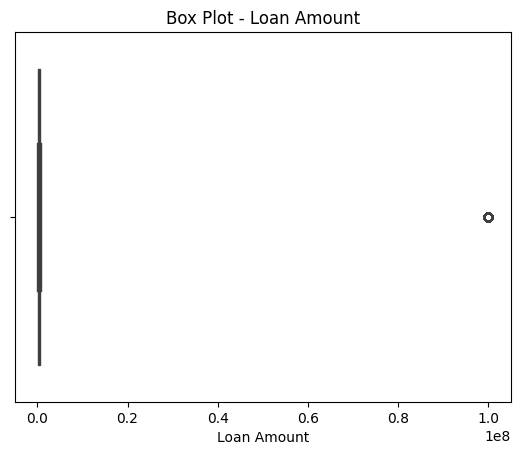

In [ ]:
outlier_range("Loan Amount")

loan amount cannot be in zero so we change lower bound as 0 and check how many data points falls outside the boundary

In [ ]:
df[(df["Loan Amount"] < 0) | (df["Loan Amount"] > 1042877.0)]

,Loan Status,Loan Amount,Term,Credit Score,Annual Income,Purpose,Number of Open Accounts
2,Fully Paid,99999999,Short Term,741.00,2231892.00,Debt Consolidation,18
10,Fully Paid,99999999,Short Term,728.00,714628.00,Debt Consolidation,16
12,Fully Paid,99999999,Short Term,740.00,776188.00,Debt Consolidation,6
13,Fully Paid,99999999,Short Term,743.00,1560907.00,Debt Consolidation,10
26,Fully Paid,99999999,Short Term,724.00,1029857.00,Debt Consolidation,6
...,...,...,...,...,...,...,...
99970,Fully Paid,99999999,Short Term,674.00,1058376.00,Other,12
99971,Fully Paid,99999999,Long Term,616.00,1530564.00,Medical Bills,10
99990,Fully Paid,99999999,Short Term,742.00,1190046.00,other,9
99996,Fully Paid,99999999,Short Term,732.00,1289416.00,Debt Consolidation,22


In [ ]:
df[(df["Loan Amount"] < 0) | (df["Loan Amount"] > 1042877.0)]["Loan Amount"].unique()

array([99999999])

There are 11484 data point's values are above outlier so we values to lower and upper boun

In [ ]:
df['Loan Amount'] = df['Loan Amount'].clip(lower=0, upper=1042877)

In [ ]:
df[(df["Loan Amount"] < 0) | (df["Loan Amount"] > 1042877.0)]["Loan Amount"].unique()

array([], dtype=int64)

re-verifying outlier for loan amount column

IQR: 345290.0
Lower Bound: -338283.0
Upper Bound: 1042877.0


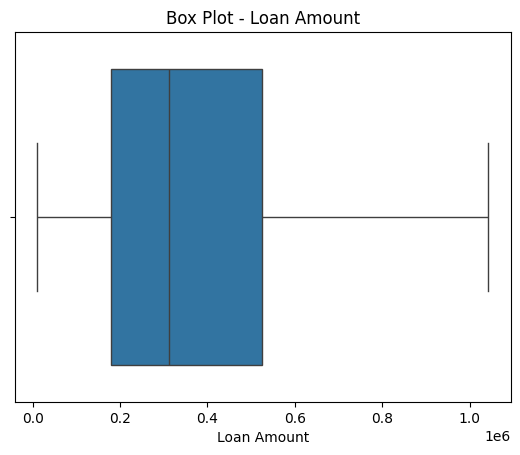

In [ ]:
outlier_range("Loan Amount")

####Credit Score

IQR: 27.0
Lower Bound: 670.5
Upper Bound: 778.5


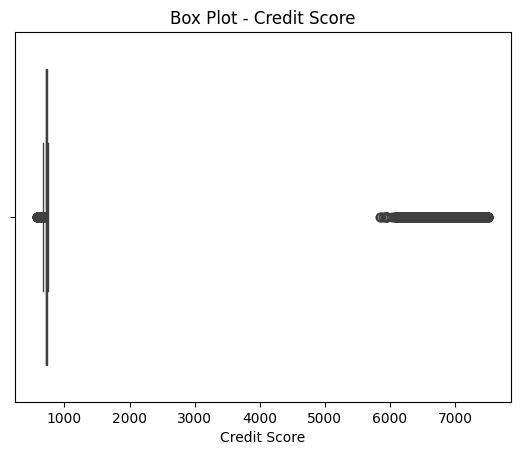

In [ ]:
outlier_range("Credit Score")

In [ ]:
df[(df["Credit Score"] < 670.5) | (df["Credit Score"] > 778.5)]

,Loan Status,Loan Amount,Term,Credit Score,Annual Income,Purpose,Number of Open Accounts
5,Charged Off,206602,Short Term,7290.00,896857.00,Debt Consolidation,6
43,Charged Off,288948,Short Term,7120.00,537472.00,Debt Consolidation,4
49,Charged Off,456808,Long Term,598.00,1096167.00,Debt Consolidation,8
51,Charged Off,219692,Long Term,6610.00,527839.00,Debt Consolidation,9
53,Charged Off,374176,Long Term,652.00,1239199.00,other,10
...,...,...,...,...,...,...,...
99947,Charged Off,205458,Long Term,6940.00,1681101.00,Business Loan,8
99948,Fully Paid,587796,Long Term,661.00,1280714.00,Other,12
99954,Charged Off,316426,Long Term,659.00,1613062.00,Debt Consolidation,25
99969,Fully Paid,457050,Long Term,655.00,943483.00,Debt Consolidation,13


In [ ]:
df['Credit Score'] = df['Credit Score'].clip(lower=670.5, upper=778.5)

IQR: 27.0
Lower Bound: 670.5
Upper Bound: 778.5


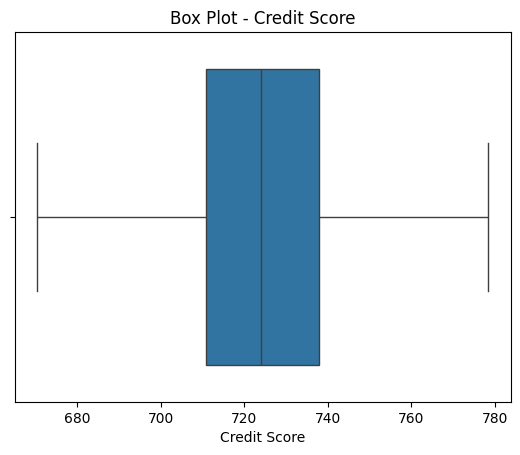

In [ ]:
outlier_range("Credit Score")

####Annual Income

IQR: 581523.5
Lower Bound: 58895.25
Upper Bound: 2384989.25


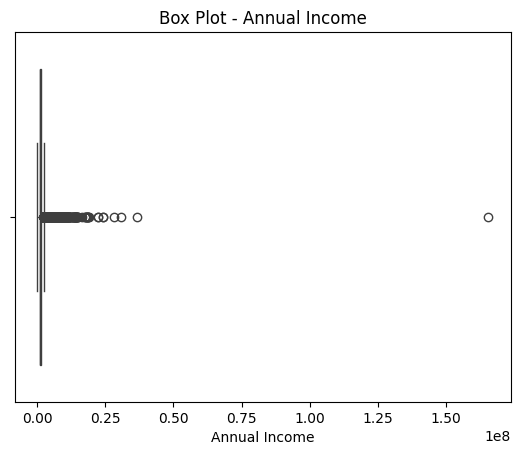

In [ ]:
outlier_range("Annual Income")

In [ ]:
df[(df["Annual Income"] < 58895.25) | (df["Annual Income"] > 2384989.25)]

,Loan Status,Loan Amount,Term,Credit Score,Annual Income,Purpose,Number of Open Accounts
8,Fully Paid,548746,Short Term,678.00,2559110.00,Debt Consolidation,4
54,Fully Paid,1042877,Long Term,730.00,2509520.00,Debt Consolidation,12
63,Fully Paid,602008,Long Term,741.00,2896721.00,Debt Consolidation,17
64,Fully Paid,171248,Short Term,747.00,3035725.00,Debt Consolidation,11
72,Fully Paid,1042877,Short Term,699.00,2770162.00,Debt Consolidation,13
...,...,...,...,...,...,...,...
99921,Fully Paid,754380,Short Term,714.00,2512940.00,Debt Consolidation,12
99930,Fully Paid,1042877,Short Term,746.00,3553323.00,Business Loan,14
99942,Fully Paid,109736,Short Term,725.00,3616593.00,other,11
99981,Charged Off,666666,Short Term,725.00,3838380.00,Debt Consolidation,18


In [ ]:
df['Annual Income'] = df['Annual Income'].clip(lower=58895.25, upper=2384989.25)

IQR: 581523.5
Lower Bound: 58895.25
Upper Bound: 2384989.25


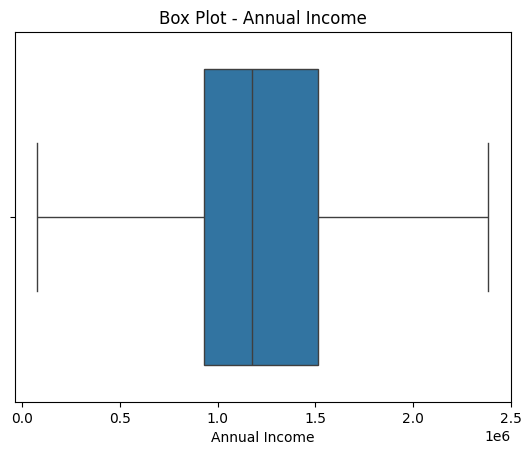

In [ ]:
outlier_range("Annual Income")

####Number of Open Accounts

IQR: 6.0
Lower Bound: -1.0
Upper Bound: 23.0


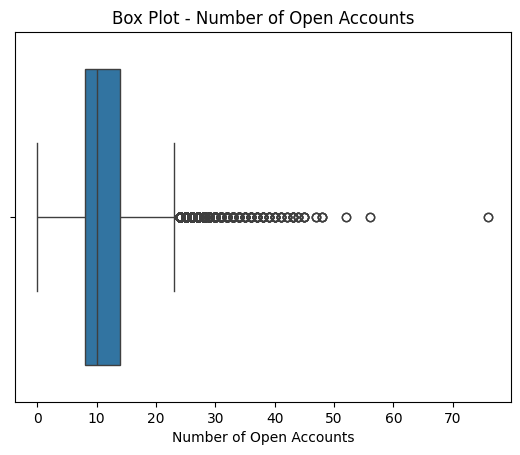

In [ ]:
outlier_range("Number of Open Accounts")

In [ ]:
df[(df["Number of Open Accounts"] < 0) | (df["Number of Open Accounts"] > 23.0)]

,Loan Status,Loan Amount,Term,Credit Score,Annual Income,Purpose,Number of Open Accounts
1,Fully Paid,262328,Short Term,724.00,1174162.00,Debt Consolidation,35
46,Fully Paid,129712,Short Term,723.00,1465698.00,Debt Consolidation,34
118,Charged Off,509586,Long Term,678.00,1816001.00,Debt Consolidation,32
274,Fully Paid,325622,Short Term,724.00,1174162.00,Debt Consolidation,25
312,Fully Paid,448712,Long Term,696.00,1264602.00,Debt Consolidation,28
...,...,...,...,...,...,...,...
99956,Fully Paid,338162,Short Term,745.00,1362851.00,Debt Consolidation,25
99967,Fully Paid,786940,Short Term,723.00,2330160.00,Debt Consolidation,31
99976,Fully Paid,333630,Short Term,724.00,1174162.00,Debt Consolidation,24
99985,Fully Paid,179454,Short Term,708.00,1356068.00,Debt Consolidation,25


In [ ]:
df['Number of Open Accounts'] = df['Number of Open Accounts'].clip(lower=0, upper=23.0)

IQR: 6.0
Lower Bound: -1.0
Upper Bound: 23.0


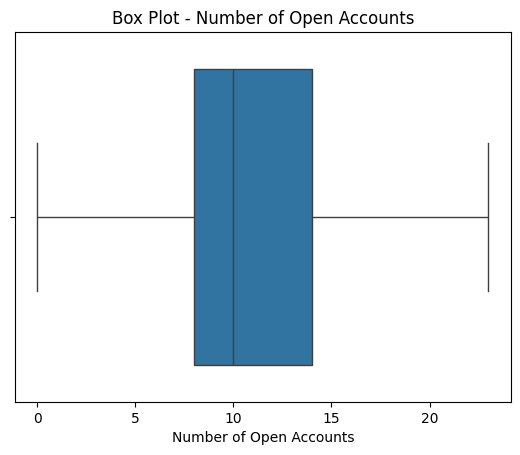

In [ ]:
outlier_range("Number of Open Accounts")

##EDA

In [ ]:
# Convert 'Loan Status' to numeric: Fully Paid = 0, Charged Off = 1
df['Loan Status'] = df['Loan Status'].map({'Fully Paid': 0, 'Charged Off': 1})


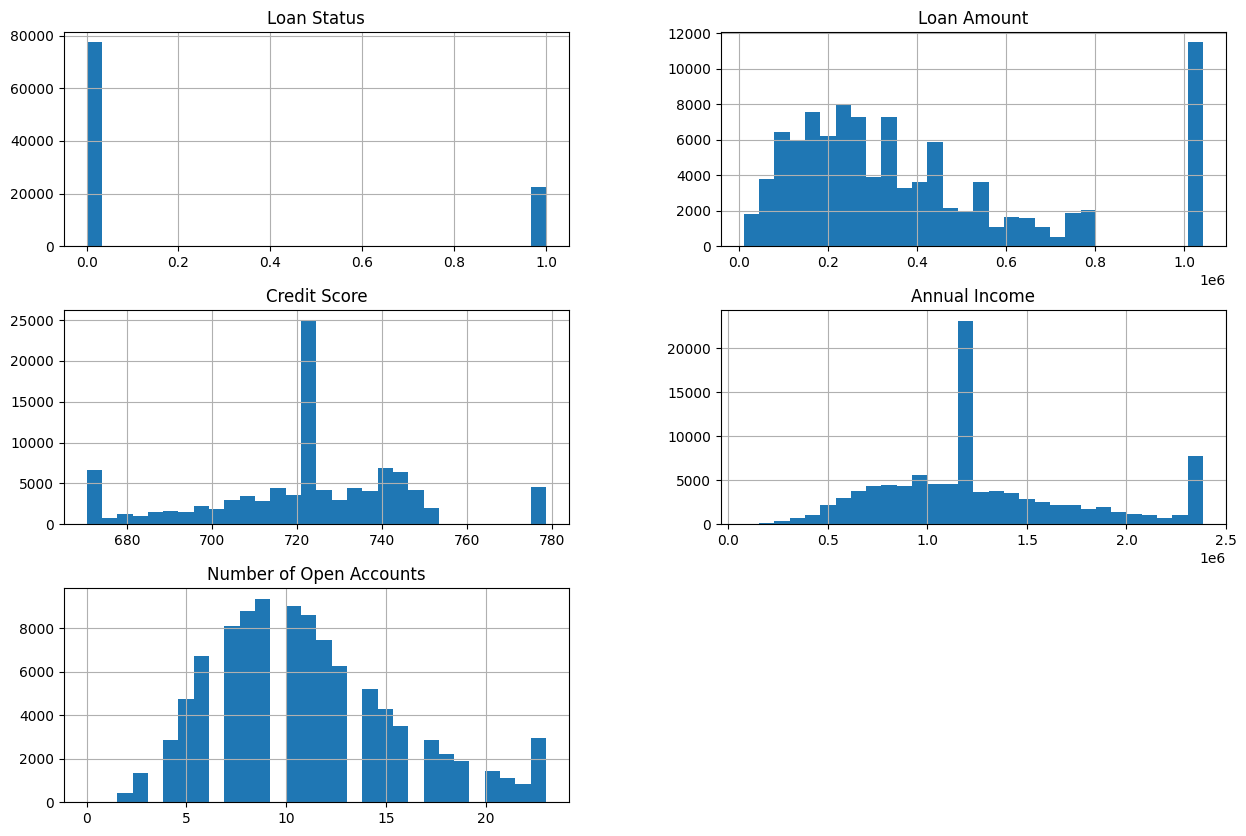

In [ ]:
# Histogram of all numeric features
df.hist(bins=30, figsize=(15, 10))
plt.show()

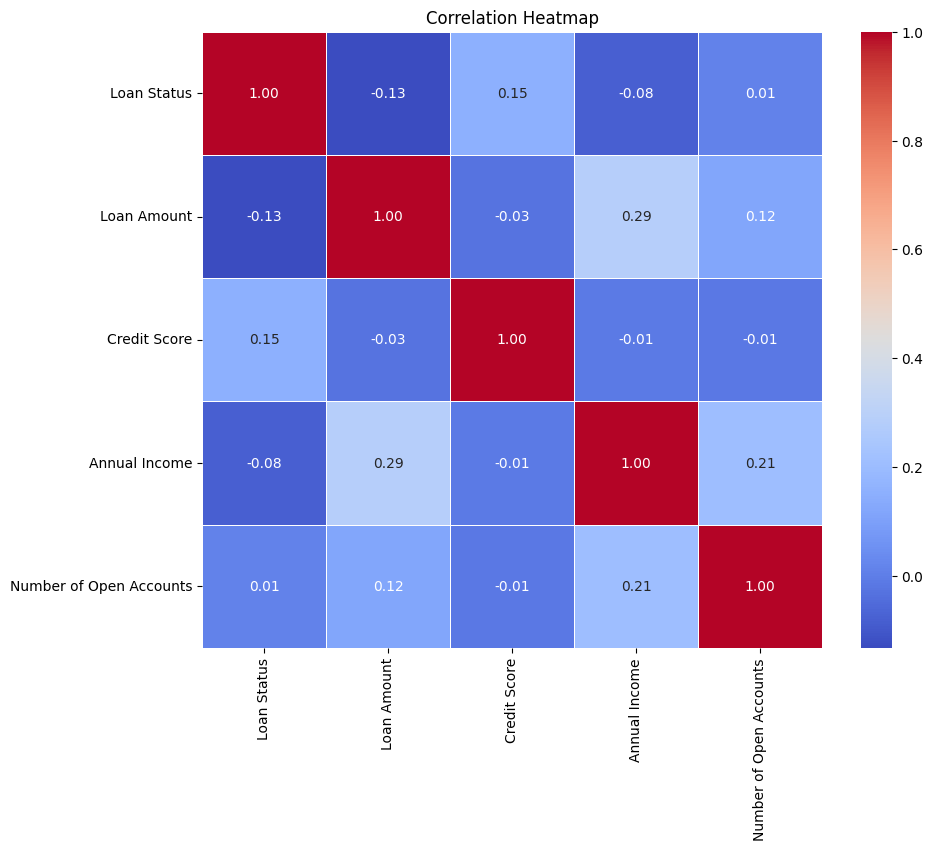

In [ ]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
corr = df[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

## Encoding

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Loan Status              100000 non-null  int64  
 1   Loan Amount              100000 non-null  int64  
 2   Term                     100000 non-null  object 
 3   Credit Score             100000 non-null  float64
 4   Annual Income            100000 non-null  float64
 5   Purpose                  100000 non-null  object 
 6   Number of Open Accounts  100000 non-null  int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 5.3+ MB


In [ ]:
df.Term.value_counts()

,count
Term,
Short Term,72208
Long Term,27792


In [ ]:
df['Term'] = df['Term'].map({'Short Term': 0, 'Long Term': 1}) #binary encoding for Term column


In [ ]:
df.Purpose.value_counts()

,count
Purpose,
Debt Consolidation,78552
other,6037
Home Improvements,5839
Other,3250
Business Loan,1569
Buy a Car,1265
Medical Bills,1127
Buy House,678
Take a Trip,573


by checking value count of purpose we found there 15 categories including other, so will move the category which has less 500 to other

In [ ]:
purpose_counts = df['Purpose'].value_counts()
rare_purposes = purpose_counts[purpose_counts < 500].index

df['Purpose'] = df['Purpose'].replace(rare_purposes, 'other')

In [ ]:
df['Purpose'] = df['Purpose'].replace('Other', 'other')

In [ ]:
df.Purpose.value_counts()

,count
Purpose,
Debt Consolidation,78552
other,10397
Home Improvements,5839
Business Loan,1569
Buy a Car,1265
Medical Bills,1127
Buy House,678
Take a Trip,573


In [ ]:
df = pd.get_dummies(df, columns=['Purpose'], drop_first=True)

In [ ]:
df

,Loan Status,Loan Amount,Term,Credit Score,Annual Income,Number of Open Accounts,Purpose_Buy House,Purpose_Buy a Car,Purpose_Debt Consolidation,Purpose_Home Improvements,Purpose_Medical Bills,Purpose_Take a Trip,Purpose_other
0,0,445412,0,709.00,1167493.00,6,False,False,False,True,False,False,False
1,0,262328,0,724.00,1174162.00,23,False,False,True,False,False,False,False
2,0,1042877,0,741.00,2231892.00,18,False,False,True,False,False,False,False
3,0,347666,1,721.00,806949.00,9,False,False,True,False,False,False,False
4,0,176220,0,724.00,1174162.00,15,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0,147070,0,725.00,475437.00,5,False,False,False,False,False,False,True
99996,0,1042877,0,732.00,1289416.00,22,False,False,True,False,False,False,False
99997,0,103136,0,742.00,1150545.00,12,False,False,True,False,False,False,False
99998,0,530332,0,746.00,1717524.00,8,False,False,True,False,False,False,False


In [ ]:
df.filter(like='Purpose_').head()

,Purpose_Buy House,Purpose_Buy a Car,Purpose_Debt Consolidation,Purpose_Home Improvements,Purpose_Medical Bills,Purpose_Take a Trip,Purpose_other
0,False,False,False,True,False,False,False
1,False,False,True,False,False,False,False
2,False,False,True,False,False,False,False
3,False,False,True,False,False,False,False
4,False,False,True,False,False,False,False


## Data Split & Scale

In [ ]:

X = df.drop('Loan Status', axis=1)
y = df['Loan Status']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


##Model Building Without balancing the dataset

###Logistic Regression

In [ ]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))

[[15458    14]
 [ 4522     6]]
              precision    recall  f1-score   support

           0       0.77      1.00      0.87     15472
           1       0.30      0.00      0.00      4528

    accuracy                           0.77     20000
   macro avg       0.54      0.50      0.44     20000
weighted avg       0.67      0.77      0.68     20000

ROC-AUC Score: 0.6227370353968962


###Decision Tree

In [ ]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)

print("Decision Tree:")
print(confusion_matrix(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))

Decision Tree:
[[13036  2436]
 [ 2568  1960]]
              precision    recall  f1-score   support

           0       0.84      0.84      0.84     15472
           1       0.45      0.43      0.44      4528

    accuracy                           0.75     20000
   macro avg       0.64      0.64      0.64     20000
weighted avg       0.75      0.75      0.75     20000



### Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("Random Forest:")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


In [ ]:
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

rf_grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=rf_param_grid,
    cv=3,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)

rf_grid.fit(X_train, y_train)
print("Best RF Parameters:", rf_grid.best_params_)
best_rf = rf_grid.best_estimator_

from sklearn.metrics import classification_report, roc_auc_score
y_pred_rf = best_rf.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, best_rf.predict_proba(X_test)[:,1]))


Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best RF Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.99      0.89     15472
           1       0.90      0.23      0.36      4528

    accuracy                           0.82     20000
   macro avg       0.86      0.61      0.63     20000
weighted avg       0.83      0.82      0.77     20000

ROC-AUC: 0.76142080067812


### XGBoost Classifier

In [ ]:
xgb = XGBClassifier(eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)

print("XGBoost:")
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

XGBoost:
[[15350   122]
 [ 3524  1004]]
              precision    recall  f1-score   support

           0       0.81      0.99      0.89     15472
           1       0.89      0.22      0.36      4528

    accuracy                           0.82     20000
   macro avg       0.85      0.61      0.62     20000
weighted avg       0.83      0.82      0.77     20000



In [ ]:

xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

# Grid Search
xgb_grid = GridSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_grid=xgb_param_grid,
    cv=3,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)

xgb_grid.fit(X_train, y_train)
print("Best XGBoost Parameters:", xgb_grid.best_params_)
best_xgb = xgb_grid.best_estimator_

# Evaluate
y_pred_xgb = best_xgb.predict(X_test)
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, best_xgb.predict_proba(X_test)[:,1]))

Fitting 3 folds for each of 72 candidates, totalling 216 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:53:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best XGBoost Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.81      1.00      0.90     15472
           1       1.00      0.21      0.34      4528

    accuracy                           0.82     20000
   macro avg       0.90      0.60      0.62     20000
weighted avg       0.85      0.82      0.77     20000

ROC-AUC: 0.7493455420780637


## Model Building After Balancing the dataset(with Smote-Enn)

### Applying Smotte-enn to do both under & over sampling

In [ ]:
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)

print("Before:", Counter(y_train))
print("After:", Counter(y_resampled))

Before: Counter({0: 61889, 1: 18111})
After: Counter({1: 28054, 0: 26908})


###Logistic Regression

In [ ]:
model = LogisticRegression(max_iter=1000)
model.fit(X_resampled, y_resampled)
y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))

[[7197 8275]
 [1457 3071]]
              precision    recall  f1-score   support

           0       0.83      0.47      0.60     15472
           1       0.27      0.68      0.39      4528

    accuracy                           0.51     20000
   macro avg       0.55      0.57      0.49     20000
weighted avg       0.70      0.51      0.55     20000

ROC-AUC Score: 0.5951002392101907


### Random Forest Classifier

In [ ]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_resampled, y_resampled)

y_pred = rf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))

[[11072  4400]
 [ 2004  2524]]
              precision    recall  f1-score   support

           0       0.85      0.72      0.78     15472
           1       0.36      0.56      0.44      4528

    accuracy                           0.68     20000
   macro avg       0.61      0.64      0.61     20000
weighted avg       0.74      0.68      0.70     20000

ROC-AUC: 0.7208785887238226


In [ ]:
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

rf_grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=rf_param_grid,
    cv=3,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)

rf_grid.fit(X_resampled, y_resampled)
print("Best RF Parameters:", rf_grid.best_params_)
best_rf = rf_grid.best_estimator_

y_pred_rf = best_rf.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, best_rf.predict_proba(X_test)[:,1]))


Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best RF Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.72      0.78     15472
           1       0.37      0.56      0.44      4528

    accuracy                           0.68     20000
   macro avg       0.61      0.64      0.61     20000
weighted avg       0.74      0.68      0.70     20000

ROC-AUC: 0.7215058331749866


### XGBoost Classifier

In [ ]:
xgb = XGBClassifier(eval_metric='logloss', random_state=42)
xgb.fit(X_resampled, y_resampled)

y_pred_xgb = xgb.predict(X_test)

print("XGBoost:")
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

XGBoost:
[[10560  4912]
 [ 1750  2778]]
              precision    recall  f1-score   support

           0       0.86      0.68      0.76     15472
           1       0.36      0.61      0.45      4528

    accuracy                           0.67     20000
   macro avg       0.61      0.65      0.61     20000
weighted avg       0.75      0.67      0.69     20000



In [ ]:

xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

# Grid Search
xgb_grid = GridSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_grid=xgb_param_grid,
    cv=3,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)

xgb_grid.fit(X_resampled, y_resampled)
print("Best XGBoost Parameters:", xgb_grid.best_params_)
best_xgb = xgb_grid.best_estimator_

# Evaluate
y_pred_xgb = best_xgb.predict(X_test)
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, best_xgb.predict_proba(X_test)[:,1]))

Fitting 3 folds for each of 72 candidates, totalling 216 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:21:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best XGBoost Parameters: {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.69      0.76     15472
           1       0.36      0.59      0.45      4528

    accuracy                           0.67     20000
   macro avg       0.61      0.64      0.61     20000
weighted avg       0.74      0.67      0.69     20000

ROC-AUC: 0.7230415564900552


## Model Building After Balancing the dataset(with Smote)

### Smote

In [ ]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print("Before:", Counter(y_train))
print("After:", Counter(y_resampled))

Before: Counter({0: 61889, 1: 18111})
After: Counter({1: 61889, 0: 61889})


###Logistic Regression

In [ ]:
model = LogisticRegression(max_iter=1000)
model.fit(X_resampled, y_resampled)
y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))

[[8237 7235]
 [1926 2602]]
              precision    recall  f1-score   support

           0       0.81      0.53      0.64     15472
           1       0.26      0.57      0.36      4528

    accuracy                           0.54     20000
   macro avg       0.54      0.55      0.50     20000
weighted avg       0.69      0.54      0.58     20000

ROC-AUC Score: 0.57741500889787


### Decision Tree

In [ ]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_resampled, y_resampled)

y_pred_dt = dt.predict(X_test)

print("Decision Tree:")
print(confusion_matrix(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))

Decision Tree:
[[12589  2883]
 [ 2380  2148]]
              precision    recall  f1-score   support

           0       0.84      0.81      0.83     15472
           1       0.43      0.47      0.45      4528

    accuracy                           0.74     20000
   macro avg       0.63      0.64      0.64     20000
weighted avg       0.75      0.74      0.74     20000



###Random Forest

In [ ]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_resampled, y_resampled)

y_pred = rf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))

[[13146  2326]
 [ 2534  1994]]
              precision    recall  f1-score   support

           0       0.84      0.85      0.84     15472
           1       0.46      0.44      0.45      4528

    accuracy                           0.76     20000
   macro avg       0.65      0.65      0.65     20000
weighted avg       0.75      0.76      0.75     20000

ROC-AUC: 0.7500551263698517


In [ ]:
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

rf_grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=rf_param_grid,
    cv=3,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)

rf_grid.fit(X_resampled, y_resampled)
print("Best RF Parameters:", rf_grid.best_params_)
best_rf = rf_grid.best_estimator_

y_pred_rf = best_rf.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, best_rf.predict_proba(X_test)[:,1]))

Fitting 3 folds for each of 48 candidates, totalling 144 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best RF Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.85      0.85     15472
           1       0.47      0.43      0.45      4528

    accuracy                           0.76     20000
   macro avg       0.65      0.64      0.65     20000
weighted avg       0.75      0.76      0.76     20000

ROC-AUC: 0.748716698933626


### XGBosst Classifier

In [ ]:
xgb = XGBClassifier(eval_metric='logloss', random_state=42)
xgb.fit(X_resampled, y_resampled)

y_pred_xgb = xgb.predict(X_test)

print("XGBoost:")
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

XGBoost:
[[12826  2646]
 [ 2554  1974]]
              precision    recall  f1-score   support

           0       0.83      0.83      0.83     15472
           1       0.43      0.44      0.43      4528

    accuracy                           0.74     20000
   macro avg       0.63      0.63      0.63     20000
weighted avg       0.74      0.74      0.74     20000



##Class weight adjust for RF

In [ ]:
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))

[[14590   882]
 [ 3151  1377]]
              precision    recall  f1-score   support

           0       0.82      0.94      0.88     15472
           1       0.61      0.30      0.41      4528

    accuracy                           0.80     20000
   macro avg       0.72      0.62      0.64     20000
weighted avg       0.77      0.80      0.77     20000

ROC-AUC: 0.750174378896244


## Conclusion

All checking multiple models with various combination like smote-enn,smote, weight adjustment with hyperparameter tuning

Class 1's performance is constantly falling under 0.5.

out of all combination. Smote balancing technic with tuned RandomForest works better with hyper parameters of

Best RF Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}

In [ ]:
rf = RandomForestClassifier(max_depth= None, max_features= 'sqrt', min_samples_leaf= 2, min_samples_split= 2, n_estimators= 200, random_state=42)
rf.fit(X_resampled, y_resampled)

y_pred = rf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))

[[13224  2248]
 [ 2566  1962]]
              precision    recall  f1-score   support

           0       0.84      0.85      0.85     15472
           1       0.47      0.43      0.45      4528

    accuracy                           0.76     20000
   macro avg       0.65      0.64      0.65     20000
weighted avg       0.75      0.76      0.76     20000

ROC-AUC: 0.748716698933626
